In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy import spatial
from scipy.stats import entropy
from numpy.linalg import norm

### Create corpus from the same author and same-size random sample

In [2]:
df = pd.read_csv('../../data/shakespare_william_works_preprocessed.tsv', sep = '\t')

In [3]:
au_list = ['AuburnRed',
 'rthstewart',
 'Jojoinabox',
 'literarypeerelief',
 'Lady_Loki',
 'Shayheyred',
 'literarypeerelief',
 'Mangaluva',
 'rthstewart',
 'RandomRavenclaw9']

In [9]:
df_all = []
df_rand_dict = {}
for au in au_list:
    df_Au = df[df.Author == au]
    df_all.append(df_Au)
    df_Rand = df.sample(len(df_Au))
    df_all.append(df_Rand)
    df_rand_dict[au] = df_Rand    
df_all = pd.concat(df_all)

In [21]:
doc_cnt = 0
word_cnt = 0
for au in au_list:
    df_Au = df[df.Author == au]
    df_Rand = df.sample(len(df_Au))

    for doc in df_Rand.Text.tolist():
        doc = process_sentence(doc)
        word_cnt += len(doc)
        doc_cnt += 1

In [12]:
au_cnt

217

In [13]:
rand_cnt

217

In [14]:
rand_au_cnt

185

In [18]:
doc_cnt

217

In [22]:
word_cnt/217

1825.700460829493

### General functions

In [4]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [5]:
def process_sentence(sentence):
    # input: sentence as a string
    # output: a list of words in the sentence
    sentence = re.sub(r'aA|aa', 'a', sentence)
    sentence = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', sentence).lower()
    sentence = re.findall(u'(?u)\\b\\w\\w+\\b', sentence)
    return sentence

In [6]:
def calc_results(au_dist,rand_dist):
    results_au = []
    results_rand = []
    for i in range(len(au_dist)):
        for j in range(i, len(au_dist)):
            results_au.append(spatial.distance.cosine(au_dist[i], au_dist[j]))
    results_au = bootstrap_resample(results_au)
    for i in range(len(rand_dist)):
        for j in range(i, len(rand_dist)):
            results_rand.append(spatial.distance.cosine(rand_dist[i], rand_dist[j]))
    results_rand = bootstrap_resample(results_rand)
    return results_au, results_rand

In [7]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [25]:
def plot(results_au, results_rand, label):
    fig = plt.figure()
    lower_error1 = [results_au[0] - results_au[1]]
    upper_error1 = [results_au[2] - results_au[0]]
    lower_error2 = [results_rand[0] - results_rand[1]]
    upper_error2 = [results_rand[2] - results_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [results_au[0], results_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0,3)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Random author'])
    plt.ylabel(label, fontsize = 14)

### tfidf weighting

In [8]:
# create a corpus to give to sklearn
def create_corpus_for_voc(df):
    doc = []
    for i in df.Text.tolist():
        #Remove some non-ascii characters and 'aa's
        i = re.sub(r'aA|aa', 'a', i)
        i = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', i)
        i = i.lower()
        doc.append(i)  
    return doc

In [15]:
vectorizer = TfidfVectorizer(min_df=1)
corpus_all = create_corpus_for_voc(df_all)
vectorizer.fit(corpus_all)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
results_au_all = [0,0,0]
results_rand_all = [0,0,0]
for au in au_list:
    df_Au = df[df.Author == au]
    df_Rand = df_rand_dict[au]
    
    corpus = create_corpus_for_voc(df_Au)
    au_dist = vectorizer.transform(corpus).todense()

    corpus = create_corpus_for_voc(df_Rand)
    rand_dist = vectorizer.transform(corpus).todense()
    
    results_au, results_rand = calc_results(au_dist,rand_dist)
    results_au_all[0] += results_au[0]
    results_au_all[1] += results_au[1]
    results_au_all[2] += results_au[2]
    results_rand_all[0] += results_rand[0]
    results_rand_all[1] += results_rand[1]
    results_rand_all[2] += results_rand[2]
    

results_au_all[0] = results_au_all[0]/len(au_list)
results_au_all[1] = results_au_all[1]/len(au_list)
results_au_all[2] = results_au_all[2]/len(au_list)
results_rand_all[0] = results_rand_all[0]/len(au_list)
results_rand_all[1] = results_rand_all[1]/len(au_list)
results_rand_all[2] = results_rand_all[2]/len(au_list)

In [18]:
print (results_au_all, results_rand_all)

[0.47816781641304174, 0.41217237192384226, 0.53710992175258077] [0.60609705113346668, 0.53806611440092689, 0.66842828202277715]


### LDA

In [19]:
from gensim import corpora, models, similarities
from nltk.corpus import stopwords

In [20]:
# create a corpus to give to sklearn
def create_sentence_list(df):
    doc = []
    stops = set(stopwords.words("english"))
    for line in df.Text.tolist():
        line = process_sentence(line)
        line = [word for word in line if word not in stops]
        doc.append(line)  
    return doc

In [21]:
def create_lda_input(sentences):
    id2word = corpora.dictionary.Dictionary(sentences)
    corpus = [id2word.doc2bow(sentence) for sentence in sentences]
    return id2word, corpus

In [22]:
def calc_results_jsd(au_dist,rand_dist):
    results_au = []
    results_rand = []
    for i in range(len(au_dist)):
        for j in range(i, len(au_dist)):
            results_au.append(JSD(au_dist[i], au_dist[j]))
    results_au = bootstrap_resample(results_au)
    for i in range(len(rand_dist)):
        for j in range(i, len(rand_dist)):
            results_rand.append(JSD(rand_dist[i], rand_dist[j]))
    results_rand = bootstrap_resample(results_rand)
    return results_au, results_rand

In [23]:
doc = create_sentence_list(df_all)
id2word,corpus = create_lda_input(doc)
lda = models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=20)

In [36]:
results_au_all_2 = [0,0,0]
results_rand_all_2 = [0,0,0]
for au in au_list:
    df_Au = df[df.Author == au]
    df_Rand = df_rand_dict[au]
    
    doc = create_sentence_list(df_Au)
    au_dist = []
    for i in range(len(doc)):
        dist = lda.get_document_topics(id2word.doc2bow(doc[i]), minimum_probability = 0)
        dist = [i[1] for i in dist]
        au_dist.append(dist)

    doc = create_sentence_list(df_Rand)
    rand_dist = []
    for i in range(len(doc)):
        dist = lda.get_document_topics(id2word.doc2bow(doc[i]), minimum_probability = 0)
        dist = [i[1] for i in dist]
        rand_dist.append(dist)
        
    results_au, results_rand = calc_results(au_dist,rand_dist)
    results_au_all_2[0] += results_au[0]
    results_au_all_2[1] += results_au[1]
    results_au_all_2[2] += results_au[2]
    results_rand_all_2[0] += results_rand[0]
    results_rand_all_2[1] += results_rand[1]
    results_rand_all_2[2] += results_rand[2]
    

results_au_all_2[0] = results_au_all_2[0]/len(au_list)
results_au_all_2[1] = results_au_all_2[1]/len(au_list)
results_au_all_2[2] = results_au_all_2[2]/len(au_list)
results_rand_all_2[0] = results_rand_all_2[0]/len(au_list)
results_rand_all_2[1] = results_rand_all_2[1]/len(au_list)
results_rand_all_2[2] = results_rand_all_2[2]/len(au_list)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


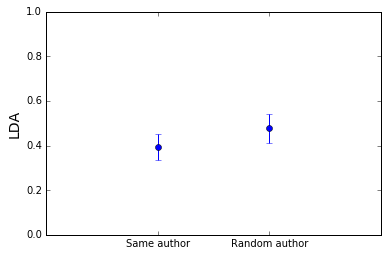

In [35]:
plot(results_au_all_2, results_rand_all_2, 'LDA')
plt.savefig('comparison_lda_10au_2.pdf', type='pdf')

### Doc2vec

In [29]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import doc2vec

In [30]:
def read_corpus(doc):
    for i, line in enumerate(doc):
        yield doc2vec.TaggedDocument(line,[i])

In [31]:
doc = create_sentence_list(df_all)
corpus = list(read_corpus(doc))
model = doc2vec.Doc2Vec(corpus, size=100)

In [32]:
results_au_all_3 = [0,0,0]
results_rand_all_3 = [0,0,0]
for au in au_list:
    df_Au = df[df.Author == au]
    df_Rand = df_rand_dict[au]
    
    doc = create_sentence_list(df_Au)
    corpus = list(read_corpus(doc))
    au_dist = []
    for doc_id in range(len(corpus)):
        inferred_vector = model.infer_vector(corpus[doc_id].words)
        au_dist.append(inferred_vector)

    doc = create_sentence_list(df_Rand)
    corpus = list(read_corpus(doc))
    rand_dist = []
    for doc_id in range(len(corpus)):
        inferred_vector = model.infer_vector(corpus[doc_id].words)
        rand_dist.append(inferred_vector)
        
    results_au, results_rand = calc_results(au_dist,rand_dist)
    results_au_all_3[0] += results_au[0]
    results_au_all_3[1] += results_au[1]
    results_au_all_3[2] += results_au[2]
    results_rand_all_3[0] += results_rand[0]
    results_rand_all_3[1] += results_rand[1]
    results_rand_all_3[2] += results_rand[2]
    

results_au_all_3[0] = results_au_all_3[0]/len(au_list)
results_au_all_3[1] = results_au_all_3[1]/len(au_list)
results_au_all_3[2] = results_au_all_3[2]/len(au_list)
results_rand_all_3[0] = results_rand_all_3[0]/len(au_list)
results_rand_all_3[1] = results_rand_all_3[1]/len(au_list)
results_rand_all_3[2] = results_rand_all_3[2]/len(au_list)

In [33]:
def plt_multiple(l1_au,l1_rand,l2_au,l2_rand,l3_au,l3_rand):
    plt.figure(figsize=(13,4))
    plt.subplot(1, 3, 1)
    lower_error1 = [l1_au[0] - l1_au[1]]
    upper_error1 = [l1_au[2] - l1_au[0]]
    lower_error2 = [l1_rand[0] - l1_rand[1]]
    upper_error2 = [l1_rand[2] - l1_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l1_au[0], l1_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('tfidf', fontsize = 14)

    plt.subplot(1, 3, 2)
    lower_error1 = [l2_au[0] - l2_au[1]]
    upper_error1 = [l2_au[2] - l2_au[0]]
    lower_error2 = [l2_rand[0] - l2_rand[1]]
    upper_error2 = [l2_rand[2] - l2_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l2_au[0], l2_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('LDA', fontsize = 14)

    plt.subplot(1, 3, 3)
    lower_error1 = [l3_au[0] - l3_au[1]]
    upper_error1 = [l3_au[2] - l3_au[0]]
    lower_error2 = [l3_rand[0] - l3_rand[1]]
    upper_error2 = [l3_rand[2] - l3_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l3_au[0], l3_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('Doc2Vec', fontsize = 14)

    plt.savefig('comparison_vec_10au.pdf', type='pdf')

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


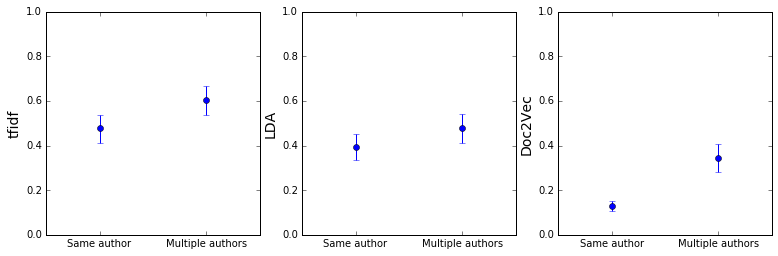

In [34]:
plt_multiple(results_au_all,results_rand_all,results_au_all_2,results_rand_all_2,results_au_all_3,results_rand_all_3)